# Task 3: Classification

In [234]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## 3.1 Classification with all features available

Our first approach is to use all the features available in the original dataset, and those we created in the previous task from those features.

In particular we can use `n_injured`, `n_unharmed` and `n_arrested` to predict `n_killed`. We can also use `n_participants`, `n_participants_adult`, `n_participants_child`, `n_participants_teen`, `n_participants_females` to predict `n_killed`.

### 3.1.1 Preparing data for classification

In [235]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [236]:
df_incidents_prepared = pd.read_csv('../dataset_preparation/incidents_prepared.csv', index_col=0)
df_orig = pd.read_csv('../dataset_preparation/original_features.csv', index_col=0)

In [237]:
df_incidents_prepared=df_incidents_prepared.join(df_orig)
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       161550 non-null  object 
 1   state                      161550 non-null  object 
 2   city_or_county             161550 non-null  object 
 3   address                    149848 non-null  object 
 4   latitude                   161550 non-null  float64
 5   longitude                  161550 non-null  float64
 6   congressional_district     161550 non-null  float64
 7   avg_age_participants       161550 non-null  float64
 8   n_killed                   161550 non-null  int64  
 9   incident_characteristics1  161550 non-null  object 
 10  year                       161550 non-null  float64
 11  age_group                  161550 non-null  object 
 12  povertyPercentage          161550 non-null  float64
 13  population                 16

Now, `incidents_prepared` is the whole dataset with both original features and features created by us.
We decided to use only the original features for what concerns the gender and age groups of the participants: we kept `n_participants`, `n_participants_adult`, `n_participants_child`, `n_participants_teen`, `n_participants_females`. We dropped `n_participants_male` because it is highly correlated with `n_participants`.

In [238]:
df_incidents_prepared['isKilled'] = df_incidents_prepared['n_killed'] > 0

In [239]:
cols2drop=[
            #categorical features difficult to encode
           'address', 'city_or_county','congressional_district','date','state', 'year_month',
           'avg_age_participants', # we already have age_group
           'n_killed',  #label
           'incident_characteristics1', # too similar to the label isKilled
           'severity', 'severity_cat', # created from n_killed

           # we decided to use original features n_females, n_injured etc. all those features are highly correlated. We decided to keep the original features because they are more interpretable
           'killed_by_district','injured_by_district', 'dfm_district_killed','dfm_district_injured', 'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen', 'dfm_district_females', 'arrested_ratio', 'unharmed_ratio', 'severity_minor',

           # correlated with n_participants
            'n_participants_adult'
            ]
df_incidents_prepared=df_incidents_prepared.drop(cols2drop, axis=1)

In [240]:
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   age_group               161550 non-null  object 
 4   povertyPercentage       161550 non-null  float64
 5   population              161550 non-null  int64  
 6   party                   161550 non-null  object 
 7   candidatevotes          161550 non-null  float64
 8   right_or_left           161550 non-null  float64
 9   voters_over_population  161550 non-null  float64
 10  n_arrested              161550 non-null  float64
 11  n_participants          161550 non-null  float64
 12  n_participants_teen     161550 non-null  float64
 13  n_participants_child    161550 non-null  float64
 14  n_females           

In [241]:
X=df_incidents_prepared.drop('isKilled', axis=1)
y=df_incidents_prepared['isKilled']

In [242]:
X.head()

,latitude,longitude,year,age_group,povertyPercentage,population,party,candidatevotes,right_or_left,voters_over_population,n_arrested,n_participants,n_participants_teen,n_participants_child,n_females,n_males,n_injured,n_unharmed
0,39.8322,-86.2492,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0
1,39.7745,-86.1166,2015.0,[25-34],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,2.0,0.0,0.0,0.0,2.0,0,0.0
2,39.7759,-86.2940,2015.0,[35-44],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,2.0,0.0,0.0,0.0,2.0,0,0.0
3,39.8040,-86.0095,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0
4,39.7882,-86.2091,2015.0,[45-54],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0


One Hot Encoding of categorical features

In [243]:
import pandas as pd
X=pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   povertyPercentage       161550 non-null  float64
 4   population              161550 non-null  int64  
 5   candidatevotes          161550 non-null  float64
 6   right_or_left           161550 non-null  float64
 7   voters_over_population  161550 non-null  float64
 8   n_arrested              161550 non-null  float64
 9   n_participants          161550 non-null  float64
 10  n_participants_teen     161550 non-null  float64
 11  n_participants_child    161550 non-null  float64
 12  n_females               161550 non-null  float64
 13  n_males                 161550 non-null  float64
 14  n_injured           

### 3.1.2 Splitting data into train and test set

In [244]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### 3.1.3 Logistic Regression

In [245]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [246]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [247]:
# fitting the model
logreg = LogisticRegression()
logreg_model = logreg.fit(X_train_scaled, y_train)

In [248]:
# predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)

In [249]:
# metrics
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.9764159702878366
confusion_matrix on training set: 
 [[90595  2310]
 [  738 35597]]
Accuracy on validation set:  0.9776539770968741
Confusion matrix: 
 [[22685   541]
 [  181  8903]]
Classification report: 
               precision    recall  f1-score   support

       False       0.99      0.98      0.98     23226
        True       0.94      0.98      0.96      9084

    accuracy                           0.98     32310
   macro avg       0.97      0.98      0.97     32310
weighted avg       0.98      0.98      0.98     32310



<Axes: >

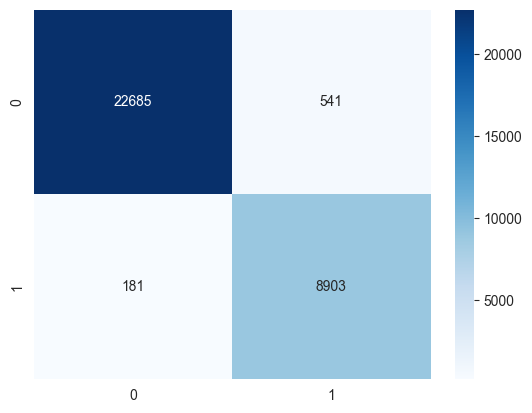

In [254]:
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

#### Discussion

We can see that the arguably simpler model of them all is almost perfect, with an accuracy of $97.8\%$ on the test set, and a F1-score of $0.97$.
Our hypothesis is that the task is almost linear due to the fact that we have the features `n_injured` and `n_unharmed`. While those two features are not directly correlated to the label, it's easy to understand that $ n_{killed} \approx n_{participants}- n_{injured}- n_{unharmed} -n_{arrested}$        in the majority of cases.

We can verify our hypothesis by looking at the weights of the model:

In [257]:
for feature, weight in zip(X.columns, logreg_model.coef_[0]):
    print(feature, weight)

latitude -0.25124512786869685
longitude -0.13040202157530473
year 0.1283046129092459
povertyPercentage -0.12676654016593625
population -0.05025305344812988
candidatevotes -0.0005995221194863229
right_or_left -0.11980699244902059
voters_over_population -0.11692770999880574
n_arrested -6.15593309302245
n_participants 6.468147365022189
n_participants_teen 0.12357442760426762
n_participants_child 0.08677346773359136
n_females 0.7730949225546132
n_males 1.707187146907592
n_injured -5.472209128545939
n_unharmed -6.485716478011078
age_group_[0-11] -0.10603199934586036
age_group_[12-17] -0.17925186895512008
age_group_[18-24] -0.04170864107591622
age_group_[25-34] 0.04768282902528395
age_group_[35-44] 0.08920300558248082
age_group_[45-54] 0.037578045018967374
age_group_[55-64] 0.05641123432518574
age_group_[65-74] 0.008325213194440679
age_group_[75-100] 0.010692710057670833
party_DEMOCRAT 0.011134922449219741
party_REPUBLICAN -0.011134922449219741


We see that the order of magnitude of the weights is between $O(1)$ and $O(10)$, for the aforementioned features, while is smaller ($O(10^{-1})$ to $O(10^{-3})$) for almost all the other. This means that the leading computation is $n_{participants}- n_{injured} - n_{unharmed} - n_{arrested}$.

For this reason, we decided to not use the features `n_injured`, `n_unharmed` and `n_arrested` in the following models.

## 3.2 Classification without 'n_injured', 'n_unharmed', and 'n_arrested'

We have seen that keeping those features leads to great results in classification, even with a simple model like logistic regression.
That is because `n_participants` $\approx$ `n_injured` + `n_unharmed` + `n_arrested`+ `n_killed`.
We decided to drop those features because, if the number of killed is unknown, it is reasonable that the number of injured, unharmed and arrested could also be unknown.

In [258]:
X.drop(['n_injured', 'n_unharmed', 'n_arrested'], axis=1, inplace=True)

In [260]:
X.head()

,latitude,longitude,year,povertyPercentage,population,candidatevotes,right_or_left,voters_over_population,n_participants,n_participants_teen,...,age_group_[12-17],age_group_[18-24],age_group_[25-34],age_group_[35-44],age_group_[45-54],age_group_[55-64],age_group_[65-74],age_group_[75-100],party_DEMOCRAT,party_REPUBLICAN
0,39.8322,-86.2492,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,1,0,0,0,0,0,0,1,0
1,39.7745,-86.1166,2015.0,12.3,6608422,61443.0,0.452677,0.203046,2.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,39.7759,-86.2940,2015.0,12.3,6608422,61443.0,0.452677,0.203046,2.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,39.8040,-86.0095,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,39.7882,-86.2091,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### 3.2.2 Decision Trees

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#### Grid search for Decision Tree Parameters

In [263]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.000 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.000 total time=   1.1s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.000 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.000 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.000 total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.000 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.000 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.000 total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.000 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.000 total t

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16],
                         'min_samples_split': [2, 4, 8, 16]},
             scoring='f1', verbose=3)

In [264]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2}

#### Finer grid search  around best parameters

In [273]:
# finer grid search around best parameters
param_grid = {'max_depth': [20, 30, 40, 50 ],
              'min_samples_split': [2,3,4],
              'criterion': ['gini']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=2;, score=0.323 total time=   2.6s
[CV 2/3] END criterion=gini, max_depth=20, min_samples_split=2;, score=0.335 total time=   1.5s
[CV 3/3] END criterion=gini, max_depth=20, min_samples_split=2;, score=0.341 total time=   1.5s
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=3;, score=0.319 total time=   1.5s
[CV 2/3] END criterion=gini, max_depth=20, min_samples_split=3;, score=0.328 total time=   2.3s
[CV 3/3] END criterion=gini, max_depth=20, min_samples_split=3;, score=0.336 total time=   2.4s
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=4;, score=0.320 total time=   1.4s
[CV 2/3] END criterion=gini, max_depth=20, min_samples_split=4;, score=0.329 total time=   1.4s
[CV 3/3] END criterion=gini, max_depth=20, min_samples_split=4;, score=0.338 total time=   1.4s
[CV 1/3] END criterion=gini, max_depth=30, min_samples_split=2;, score=0.36

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [20, 30, 40, 50],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1', verbose=3)

In [274]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 2}

In [275]:
#best parameters
tree = DecisionTreeClassifier(random_state=42, max_depth=grid.best_params_['max_depth'], min_samples_split=grid.best_params_['min_samples_split'], criterion=grid.best_params_['criterion'])
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, random_state=42)

#### Metrics

In [276]:
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)
print('Best decision Tree model trained on whole development set (unbalanced)')
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))


Best decision Tree model trained on whole development set (unbalanced)
Accuracy on training set:  0.9974698235840297
confusion_matrix on training set: 
 [[92895    10]
 [  317 36018]]
Accuracy on validation set:  0.6498297740637573
Confusion matrix: 
 [[17485  5741]
 [ 5573  3511]]
Classification report: 
               precision    recall  f1-score   support

       False       0.76      0.75      0.76     23226
        True       0.38      0.39      0.38      9084

    accuracy                           0.65     32310
   macro avg       0.57      0.57      0.57     32310
weighted avg       0.65      0.65      0.65     32310



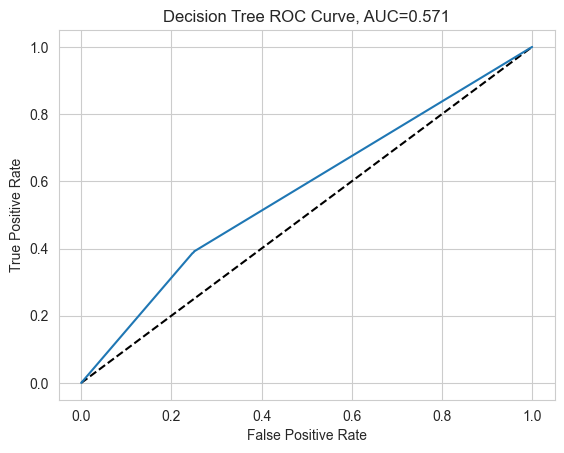

In [277]:
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = tree.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Decision Tree ROC Curve, AUC={ roc_auc_score(y_test, y_pred_proba):.3f}')

plt.show()


#### Try balancing data

##### Undersampling

In [278]:
from imblearn.under_sampling import RandomUnderSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rus = RandomUnderSampler(random_state=41)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
y_undersampled.value_counts()

False    36458
True     36458
Name: isKilled, dtype: int64

In [279]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
f1 = make_scorer(f1_score, pos_label =True)
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X_undersampled, y_undersampled)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.626 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.631 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.635 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.626 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.631 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.635 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.626 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.631 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.635 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.626 total t

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16],
                         'min_samples_split': [2, 4, 8, 16]},
             scoring='f1', verbose=3)

In [280]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 16}

In [281]:
# new grid
param_grid = {'max_depth': [4,5,6,7,8],
              'min_samples_split': [6,7,8,9,10],
              'criterion': ['gini']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X_undersampled, y_undersampled)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=6;, score=0.626 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=6;, score=0.631 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=6;, score=0.635 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=7;, score=0.626 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=7;, score=0.631 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=7;, score=0.635 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.626 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.631 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.635 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=9;, score=0.626 total ti

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 5, 6, 7, 8],
                         'min_samples_split': [6, 7, 8, 9, 10]},
             scoring='f1', verbose=3)

In [282]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 6}

In [286]:
tree_balanced = DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=16,  criterion='gini')
tree_balanced.fit(X_undersampled, y_undersampled)

DecisionTreeClassifier(max_depth=8, min_samples_split=16, random_state=42)

In [287]:
y_pred = tree_balanced.predict(X_test)
y_pred_train = tree_balanced.predict(X_undersampled)
print('Accuracy on training set: ', accuracy_score(y_undersampled, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_undersampled, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.6322480662680344
confusion_matrix on training set: 
 [[21274 15184]
 [11631 24827]]
Accuracy on validation set:  0.5929743113587125
Confusion matrix: 
 [[13200 10149]
 [ 3002  5959]]
Classification report: 
               precision    recall  f1-score   support

       False       0.81      0.57      0.67     23349
        True       0.37      0.66      0.48      8961

    accuracy                           0.59     32310
   macro avg       0.59      0.62      0.57     32310
weighted avg       0.69      0.59      0.61     32310



##### Oversampling

In [167]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
y_oversampled.value_counts()

False    92782
True     92782
Name: isKilled, dtype: int64

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
f1 = make_scorer(f1_score, pos_label =True)
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X_oversampled, y_oversampled)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.765 total time=   1.1s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.769 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.768 total time=   1.1s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.765 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.769 total time=   0.6s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.768 total time=   1.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.765 total time=   0.9s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.769 total time=   0.8s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.768 total time=   1.0s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.765 total t

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16],
                         'min_samples_split': [2, 4, 8, 16]},
             scoring='f1', verbose=3)

In [116]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2}

In [165]:
tree_oversampled = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_split=6,  criterion='gini')
tree_oversampled.fit(X_oversampled, y_oversampled)

DecisionTreeClassifier(max_depth=16, min_samples_split=6, random_state=42)

In [166]:
y_pred = tree_oversampled.predict(X_test)
y_pred_train = tree_oversampled.predict(X_oversampled)
print('Accuracy on training set: ', accuracy_score(y_oversampled, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_oversampled, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.841666487034123
confusion_matrix on training set: 
 [[73142 19640]
 [ 9741 83041]]
Accuracy on validation set:  0.7363354998452492
Confusion matrix: 
 [[17177  6172]
 [ 2347  6614]]
Classification report: 
               precision    recall  f1-score   support

       False       0.88      0.74      0.80     23349
        True       0.52      0.74      0.61      8961

    accuracy                           0.74     32310
   macro avg       0.70      0.74      0.70     32310
weighted avg       0.78      0.74      0.75     32310



##### SMOTE

### KNN

In [140]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [145]:
# train model
accuracy_scores = []
f1_scores =[]
for i in tqdm(range(1, 10)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

100%|██████████| 9/9 [02:02<00:00, 13.59s/it]


Text(0.5, 1.0, 'accuracy and f1-score for different k values')

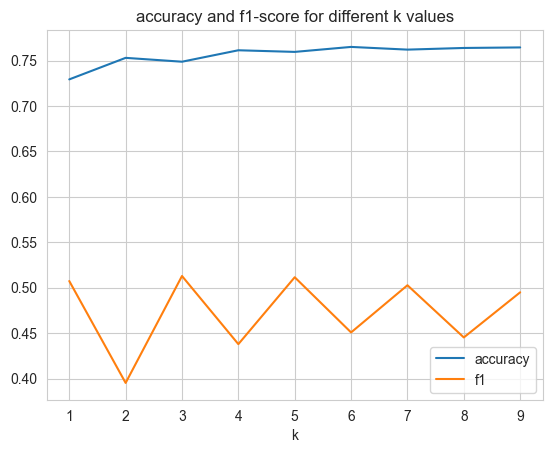

In [146]:
plt.plot(range(1, 10), accuracy_scores)
plt.plot(range(1, 10), f1_scores)
plt.xlabel('k')
plt.legend(['accuracy' ,'f1'])
plt.title('accuracy and f1-score for different k values')



In [147]:
# train again with best k on whole dev set
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on test set:  0.7596409780253791
Confusion matrix: 
 [[20478  2871]
 [ 4895  4066]]
Classification report: 
               precision    recall  f1-score   support

       False       0.81      0.88      0.84     23349
        True       0.59      0.45      0.51      8961

    accuracy                           0.76     32310
   macro avg       0.70      0.67      0.68     32310
weighted avg       0.75      0.76      0.75     32310



### Logistic regression

In [92]:
X_train

,latitude,longitude,year,povertyPercentage,population,candidatevotes,right_or_left,voters_over_population,n_participants,n_females,...,age_group_[12-17],age_group_[18-24],age_group_[25-34],age_group_[35-44],age_group_[45-54],age_group_[55-64],age_group_[65-74],age_group_[75-100],party_DEMOCRAT,party_REPUBLICAN
72096,41.5094,-87.3501,2016.0,11.8,6634304,207515.0,0.184883,0.400700,2.0,0.0,...,0,1,0,0,0,0,0,0,1,0
159077,30.0788,-95.4261,2015.0,14.0,27470056,101936.0,0.679456,0.162122,4.0,0.0,...,0,1,0,0,0,0,0,0,0,1
124316,34.1473,-77.8766,2017.0,13.6,10268233,211801.0,0.609138,0.447833,2.0,1.0,...,0,0,0,1,0,0,0,0,0,1
144416,42.4051,-82.9640,2017.0,10.7,9973114,244135.0,0.214934,0.468350,1.0,0.0,...,0,0,0,0,0,1,0,0,1,0
41932,33.5675,-112.1560,2014.0,18.1,6730413,128710.0,0.758117,0.218055,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122307,40.8303,-73.9478,2016.0,11.8,19633428,207194.0,0.188235,0.397300,3.0,0.0,...,0,0,1,0,0,0,0,0,1,0
105898,36.8071,-119.6720,2016.0,12.5,39167117,158755.0,0.675651,0.342482,3.0,0.0,...,0,0,1,0,0,0,0,0,0,1
134581,42.7352,-87.7959,2014.0,11.0,5751525,182316.0,0.632668,0.409557,2.0,0.0,...,1,0,0,0,0,0,0,0,0,1
149666,27.3226,-80.3804,2017.0,12.8,20963613,201488.0,0.535989,0.421560,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logreg = LogisticRegression()
logreg_model = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.7352367688022284
confusion_matrix on training set: 
 [[85702  7080]
 [27138  9320]]
Accuracy on validation set:  0.7373878056329309
Confusion matrix: 
 [[21575  1774]
 [ 6711  2250]]
Classification report: 
               precision    recall  f1-score   support

       False       0.76      0.92      0.84     23349
        True       0.56      0.25      0.35      8961

    accuracy                           0.74     32310
   macro avg       0.66      0.59      0.59     32310
weighted avg       0.71      0.74      0.70     32310



In [94]:
# weights of model
for i in zip(X.columns, logreg_model.coef_[0]):
    print(i)

('latitude', -0.22691250734656887)
('longitude', -0.1345313800112381)
('year', 0.04517083613502728)
('povertyPercentage', 0.006232838324137299)
('population', -0.04485873722895585)
('candidatevotes', 0.07737770772894101)
('right_or_left', -0.25058822943825504)
('voters_over_population', -0.2134447414103283)
('n_participants', 0.4607719484178424)
('n_females', 0.06590461710916817)
('n_teens', -0.003972764296771843)
('n_children', 0.029711379332977256)
('n_injured', -1.0778567064453866)
('age_group_[0-11]', -0.053281099514143775)
('age_group_[12-17]', -0.1377974671670315)
('age_group_[18-24]', -0.08509522353840995)
('age_group_[25-34]', 0.02799710222386613)
('age_group_[35-44]', 0.06762885756513441)
('age_group_[45-54]', 0.08835807658420265)
('age_group_[55-64]', 0.07135393719270403)
('age_group_[65-74]', 0.03955356385425818)
('age_group_[75-100]', 0.033195025406183784)
('party_DEMOCRAT', 0.005182070158533279)
('party_REPUBLICAN', -0.005182070158533279)


In [259]:
# correlation n_killed and n_injured
df_orig['isKilled'] = df_incidents_prepared['isKilled']
df_orig['isInjured'] = df_orig['n_injured'] > 0
df_orig['isKilled'].corr(df_orig['isInjured'])

-0.3597385293540303

### Random Forest

In [167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [169]:
# grid search for random forest
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [ 2, 4, 8],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [ 20, 30, 50]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)

grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.025 total time=   2.8s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.005 total time=   0.9s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.010 total time=   0.9s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.026 total time=   1.4s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.009 total time=   1.4s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.016 total time=   1.4s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=50;, score=0.044 total time=   2.4s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=50;, score=0.043 total time=   2.3s
[CV 3/3] END criterion=gini, max_depth=4, 

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [20, 30, 50]},
             scoring='f1', verbose=3)

In [170]:
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 16,
 'min_samples_split': 2,
 'n_estimators': 50}

In [171]:
# train model
rf = RandomForestClassifier(random_state=42, max_depth=16, min_samples_split=2, criterion='gini', n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.8584571340142371
confusion_matrix on training set: 
 [[87878  4904]
 [13389 23069]]
Accuracy on validation set:  0.7935004642525534
Confusion matrix: 
 [[21256  2093]
 [ 4579  4382]]
Classification report: 
               precision    recall  f1-score   support

       False       0.82      0.91      0.86     23349
        True       0.68      0.49      0.57      8961

    accuracy                           0.79     32310
   macro avg       0.75      0.70      0.72     32310
weighted avg       0.78      0.79      0.78     32310



In [173]:
#new gs around best parameters max_depth =16, min_samples_split=2, criterion='gini', n_estimators=50
param_grid_rf2 = {'max_depth': [16, 18, 20],
              'min_samples_split': [ 2, 3, 4],
              'criterion': ['gini'],
              'n_estimators': [ 50, 60, 70]
}
grid_rf2 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf2, cv=3, scoring='f1', verbose =3)
grid_rf2.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=50;, score=0.564 total time=   7.1s
[CV 2/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=50;, score=0.574 total time=   7.3s
[CV 3/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=50;, score=0.563 total time=   8.5s
[CV 1/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=60;, score=0.565 total time=   8.4s
[CV 2/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=60;, score=0.574 total time=   8.0s
[CV 3/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=60;, score=0.563 total time=   8.1s
[CV 1/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=70;, score=0.564 total time=   9.5s
[CV 2/3] END criterion=gini, max_depth=16, min_samples_split=2, n_estimators=70;, score=0.574 total time=  10.2s
[CV 3/3] END criterion=gini, max_de

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [16, 18, 20],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 60, 70]},
             scoring='f1', verbose=3)

In [174]:
grid_rf2.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 3,
 'n_estimators': 70}

best_params= {'criterion': 'gini',
               'max_depth': 20,
               'min_samples_split': 3,
               'n_estimators': 70}

In [175]:
best_rf = RandomForestClassifier(random_state=42, max_depth=grid_rf2.best_params_['max_depth'], min_samples_split=grid_rf2.best_params_['min_samples_split'], criterion='gini', n_estimators=grid_rf2.best_params_['n_estimators'])

In [176]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))


Accuracy on training set:  0.9131692974311358
confusion_matrix on training set: 
 [[89936  2846]
 [ 8376 28082]]
Accuracy on validation set:  0.7952646239554317
Confusion matrix: 
 [[21058  2291]
 [ 4324  4637]]
Classification report: 
               precision    recall  f1-score   support

       False       0.83      0.90      0.86     23349
        True       0.67      0.52      0.58      8961

    accuracy                           0.80     32310
   macro avg       0.75      0.71      0.72     32310
weighted avg       0.79      0.80      0.79     32310



In [177]:
X_train

,latitude,longitude,year,povertyPercentage,population,candidatevotes,right_or_left,voters_over_population,n_participants_teen,n_participants_child,...,age_group_[12-17],age_group_[18-24],age_group_[25-34],age_group_[35-44],age_group_[45-54],age_group_[55-64],age_group_[65-74],age_group_[75-100],party_DEMOCRAT,party_REPUBLICAN
72096,41.5094,-87.3501,2016.0,11.8,6634304,207515.0,0.184883,0.400700,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
159077,30.0788,-95.4261,2015.0,14.0,27470056,101936.0,0.679456,0.162122,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
124316,34.1473,-77.8766,2017.0,13.6,10268233,211801.0,0.609138,0.447833,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
144416,42.4051,-82.9640,2017.0,10.7,9973114,244135.0,0.214934,0.468350,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
41932,33.5675,-112.1560,2014.0,18.1,6730413,128710.0,0.758117,0.218055,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122307,40.8303,-73.9478,2016.0,11.8,19633428,207194.0,0.188235,0.397300,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
105898,36.8071,-119.6720,2016.0,12.5,39167117,158755.0,0.675651,0.342482,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
134581,42.7352,-87.7959,2014.0,11.0,5751525,182316.0,0.632668,0.409557,1.0,0.0,...,1,0,0,0,0,0,0,0,0,1
149666,27.3226,-80.3804,2017.0,12.8,20963613,201488.0,0.535989,0.421560,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


### SVC

In [ ]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

## 3.3 Classification using n_injured and n_participants

In [301]:
X=df_incidents_prepared.drop('isKilled', axis=1)

In [302]:
X.drop(['n_unharmed', 'n_arrested'], axis=1, inplace=True)

In [303]:
X.head()

,latitude,longitude,year,age_group,povertyPercentage,population,party,candidatevotes,right_or_left,voters_over_population,n_participants,n_participants_teen,n_participants_child,n_females,n_males,n_injured
0,39.8322,-86.2492,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,0.0,0.0,0.0,1.0,1
1,39.7745,-86.1166,2015.0,[25-34],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,2.0,0.0,0.0,0.0,2.0,0
2,39.7759,-86.2940,2015.0,[35-44],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,2.0,0.0,0.0,0.0,2.0,0
3,39.8040,-86.0095,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,0.0,0.0,0.0,1.0,0
4,39.7882,-86.2091,2015.0,[45-54],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,0.0,0.0,0.0,1.0,1


In [304]:
# one hot encoding
X=pd.get_dummies(X)

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Decision Tree

In [306]:
# grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.537 total time=   1.8s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.571 total time=   0.6s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.560 total time=   1.4s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.537 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.571 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.560 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.537 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.571 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.560 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.537 total t

KeyboardInterrupt: 

In [310]:
# train model
tree = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_split=16, criterion='gini')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))


Accuracy on training set:  0.842007118539152
confusion_matrix on training set: 
 [[85060  7722]
 [12697 23761]]
Accuracy on validation set:  0.77669452181987
Confusion matrix: 
 [[20349  3000]
 [ 4215  4746]]
Classification report: 
               precision    recall  f1-score   support

       False       0.83      0.87      0.85     23349
        True       0.61      0.53      0.57      8961

    accuracy                           0.78     32310
   macro avg       0.72      0.70      0.71     32310
weighted avg       0.77      0.78      0.77     32310



### Random Forest

In [312]:
# grid search

param_grid_rf = {'max_depth': [4, 8, 16],
              'min_samples_split': [ 2, 4, 8],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [ 20, 30, 50]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1', verbose =3)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.023 total time=   1.7s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.020 total time=   1.7s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.035 total time=   2.7s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.037 total time=   3.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.037 total time=   2.7s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.040 total time=   2.7s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=50;, score=0.053 total time=   4.1s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=50;, score=0.038 total time=   4.3s
[CV 3/3] END criterion=gini, max_depth=4, 

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [20, 30, 50]},
             scoring='f1', verbose=3)

In [314]:
grid_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 16,
 'min_samples_split': 2,
 'n_estimators': 50}

In [315]:
# train model
rf = RandomForestClassifier(random_state=42, max_depth=grid_rf.best_params_['max_depth'], min_samples_split=grid_rf.best_params_['min_samples_split'], criterion=grid_rf.best_params_['criterion'], n_estimators=grid_rf.best_params_['n_estimators'])


In [316]:
rf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=16, n_estimators=50,
                       random_state=42)

In [317]:
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))


Accuracy on training set:  0.8587511606313835
confusion_matrix on training set: 
 [[87332  5450]
 [12805 23653]]
Accuracy on validation set:  0.7969359331476323
Confusion matrix: 
 [[21158  2191]
 [ 4370  4591]]
Classification report: 
               precision    recall  f1-score   support

       False       0.83      0.91      0.87     23349
        True       0.68      0.51      0.58      8961

    accuracy                           0.80     32310
   macro avg       0.75      0.71      0.72     32310
weighted avg       0.79      0.80      0.79     32310



<Axes: >

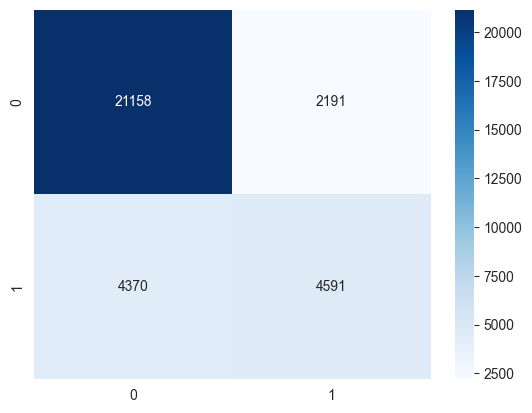

In [326]:
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')


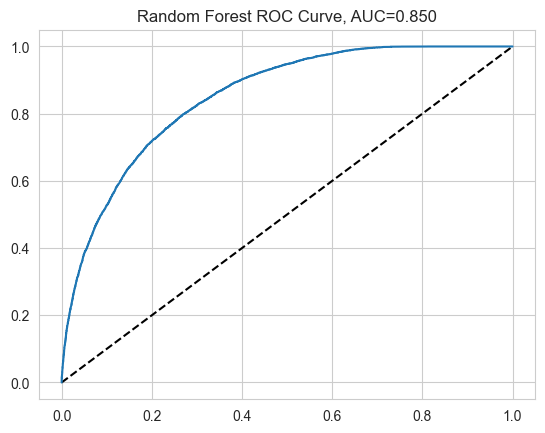

In [325]:
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'Random Forest ROC Curve, AUC={ roc_auc_score(y_test, y_pred_proba):.3f}')
plt.show()

In [329]:
# undersampling
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
y_undersampled.value_counts()


False    29166
True     29166
Name: isKilled, dtype: int64

In [328]:
# grid search with hold out set X_val
from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid_rf = {'max_depth': [4, 8, 16],
              'min_samples_split': [ 2, 4, 8],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [ 20, 30, 50]
}





ImportError: cannot import name 'GridSearch' from 'sklearn.model_selection' (C:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\__init__.py)

In [343]:
from itertools import product

def hold_out_gs( X_train, y_train, X_val, y_val, param_grid, model, cv=3, scoring='f1', verbose=1):
    """
    Performs grid search on X_train, y_train, and evaluates the best model on X_val, y_val
    """
    params = list[(product(*param_grid.values()))]
    print(params)
    best_score = 0
    best_params = None
    for param in params:
        score_fold=np.zeros(cv)
        for i in range(cv):
            param = dict(zip(param_grid.keys(), param))
            model.set_params(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            score_fold[i] = f1_score(y_val, y_pred)
            if verbose:
                print(f'params: {param}, score: {score_fold[i]}')
        score = score_fold.mean()
        if score > best_score:
            best_score = score
            best_params = param

In [344]:
hold_out_gs(X_undersampled, y_undersampled, X_val, y_val, param_grid_rf, RandomForestClassifier(random_state=42))

list[<itertools.product object at 0x000001B1A0F02540>]


TypeError: 'types.GenericAlias' object is not iterable